In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import myd2l

In [2]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)
x_test = torch.arange(0, 5, 0.1)
n_test = len(x_test)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, ))
y_truth = f(x_test)

In [3]:
def plot_kernel_reg(y_hat):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.grid(True)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.plot(x_test, y_truth, label='Truth')
    ax.plot(x_test, y_hat, c='purple', linestyle='--', label='Pred')
    ax.plot(x_train, y_train, 'o', alpha=0.5)
    plt.legend()
    plt.show()

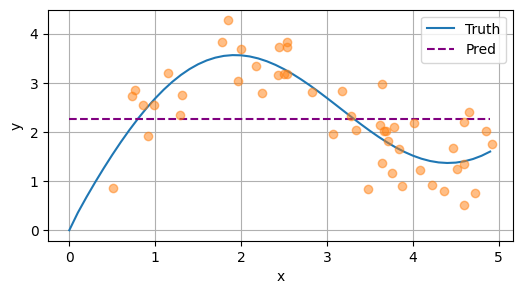

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

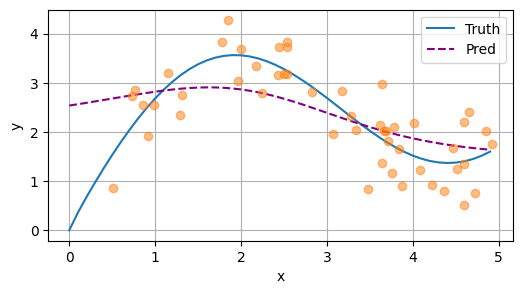

In [5]:
x_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)
attention_weights = nn.functional.softmax(-(x_repeat - x_train)**2 / 2, dim=1)
y_hat = attention_weights @ y_train
plot_kernel_reg(y_hat)

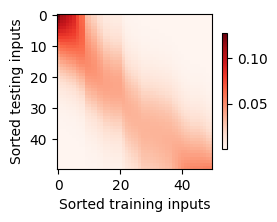

In [6]:
myd2l.show_heatmaps(attention_weights.reshape(1, 1, attention_weights.shape[0], attention_weights.shape[1]), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

In [7]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [8]:
class NWkernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))
    
    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attentino_weights = nn.functional.softmax(-((queries - keys) * self.w)**2, dim=1)
        
        return torch.bmm(self.attentino_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)
    

In [9]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, - 1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))


epoch 1, loss 31.709715
epoch 5, loss 20.963697
epoch 10, loss 19.344263
epoch 15, loss 18.907835
epoch 20, loss 18.714073
epoch 25, loss 18.607195
epoch 30, loss 18.540621
epoch 35, loss 18.495789
epoch 40, loss 18.463905
epoch 45, loss 18.440323
epoch 50, loss 18.422337
epoch 55, loss 18.408281
epoch 60, loss 18.397085
epoch 65, loss 18.388020
epoch 70, loss 18.380585
epoch 75, loss 18.374413
epoch 80, loss 18.369240
epoch 85, loss 18.364868
epoch 90, loss 18.361145
epoch 95, loss 18.357952
epoch 100, loss 18.355200


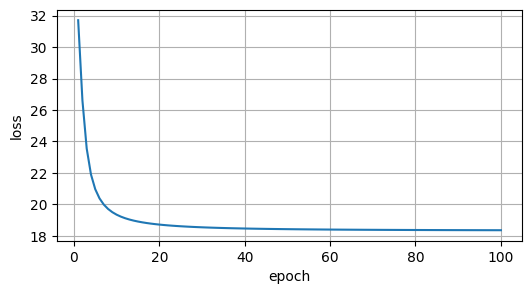

In [10]:
net = NWkernelRegression()
loss = nn.MSELoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)

losses = []
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_hat = net(x_train, keys, values)
    l = loss(y_hat, y_train)
    l.sum().backward()
    losses.append(l.sum().item())
    optimizer.step()

    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(f'epoch {epoch + 1:d}, loss {l.sum():.6f}')

fig, ax = plt.subplots(figsize=(6, 3))
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.plot(range(1, num_epochs + 1), losses)
plt.show()

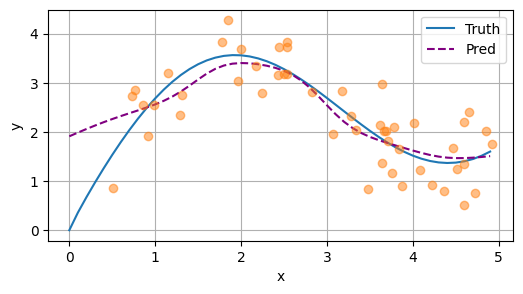

In [11]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).detach().numpy()
plot_kernel_reg(y_hat)


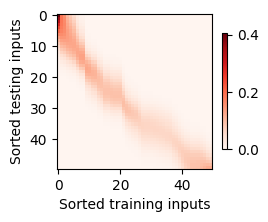

In [12]:
myd2l.show_heatmaps(net.attentino_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')